# San Francisco Uber Mobility Data Analysis for Public Transit

This notebook used Uber Mobility data first Quarter 1, 2020. The "traversals" variable in the dataset is the number of Uber rides that pass through the corresponding hexagonal area between 10:00 AM to 6:00 PM on a daily basis.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/san-francisco-uber-mobility-data-q1-2020/san_francisco-traversals_Q12020_10-6.csv


Import Necessary Libraries below:

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import contextily as ctx

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from sklearn.cluster import KMeans
from pandas import DataFrame
from scipy.stats import skewnorm

In [4]:
df = pd.read_csv("/kaggle/input/san-francisco-uber-mobility-data-q1-2020/san_francisco-traversals_Q12020_10-6.csv")

In [5]:
df["dayType"].value_counts()

weekday    58855
weekend    40958
Name: dayType, dtype: int64

In [6]:
df_weekday = df[df["dayType"] == "weekday"]

In [7]:
df_weekday.head()

hexid  dayType  traversals  \
0  8c283082e2561ff  weekday        1032   
1  8c283082e2569ff  weekday         892   
2  8c283082e2549ff  weekday         990   
3  8c283082e262bff  weekday         398   
4  8c283082e2633ff  weekday         416   

                                         wktGeometry  
0  POLYGON ((-122.40206953427416 37.7714520565948...  
1  POLYGON ((-122.40213131278361 37.7712839848525...  
2  POLYGON ((-122.40261741706829 37.7710182076871...  
3  POLYGON ((-122.40422609029275 37.7703400835882...  
4  POLYGON ((-122.40467724483703 37.7706977341065...

In [8]:
df_weekday.dtypes

hexid          object
dayType        object
traversals      int64
wktGeometry    object
dtype: object

In [9]:
df_weekday["wktGeometry"][0]

'POLYGON ((-122.40206953427416 37.77145205659484, -122.40197821984188 37.77152436450601, -122.40200775554032 37.771620128151376, -122.40212860581218 37.771643583808135, -122.4022199201558 37.77157127584822, -122.4021903843163 37.771475512280276, -122.40206953427416 37.77145205659484))'

In [10]:
df_weekday["wktGeometry_Points"] = df_weekday["wktGeometry"].str.replace("POLYGON ((", "", regex = False)
df_weekday["wktGeometry_Points"] = df_weekday["wktGeometry_Points"].str.replace("))", "", regex = False)
df_weekday["wktGeometry_Points"] = df_weekday["wktGeometry_Points"].str.split(",")

/tmp/ipykernel_21/48918236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekday["wktGeometry_Points"] = df_weekday["wktGeometry"].str.replace("POLYGON ((", "", regex = False)
/tmp/ipykernel_21/48918236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekday["wktGeometry_Points"] = df_weekday["wktGeometry_Points"].str.replace("))", "", regex = False)
/tmp/ipykernel_21/48918236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [11]:
assert any(df_weekday["wktGeometry_Points"].str.len() == 7)

In [12]:
df_weekday["Traversal Bucket"] = ""
df_weekday.loc[(df_weekday['traversals'] < 50) & (df_weekday["traversals"] > 0), 'Traversal Bucket'] = 'i. 0-50'
df_weekday.loc[(df_weekday['traversals'] < 100) & (df_weekday["traversals"] >= 50), 'Traversal Bucket'] = 'ii. 50-100'
df_weekday.loc[(df_weekday['traversals'] < 200) & (df_weekday["traversals"] >= 100), 'Traversal Bucket'] = 'iii. 100-200'
df_weekday.loc[(df_weekday['traversals'] < 500) & (df_weekday["traversals"] >= 200), 'Traversal Bucket'] = 'iv. 200-500'
df_weekday.loc[(df_weekday['traversals'] < 1000) & (df_weekday["traversals"] >= 500), 'Traversal Bucket'] = 'v. 500-1000'
df_weekday.loc[(df_weekday["traversals"] >= 1000), 'Traversal Bucket'] = 'vi. 1000+'

/tmp/ipykernel_21/617486694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekday["Traversal Bucket"] = ""


In [13]:
gp_df_weekday = gpd.GeoDataFrame(df_weekday, geometry = df_weekday["wktGeometry"].apply(shapely.wkt.loads))

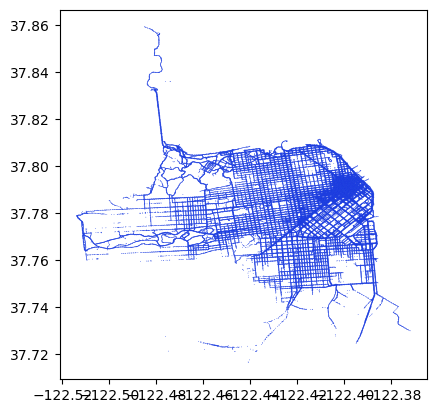

In [14]:
gp_df_weekday.plot(edgecolor = "blue", linewidth=0.1)
plt.show()

'POLYGON ((-122.40206953427416 37.77145205659484, -122.40197821984188 37.77152436450601, -122.40200775554032 37.771620128151376, -122.40212860581218 37.771643583808135, -122.4022199201558 37.77157127584822, -122.4021903843163 37.771475512280276, -122.40206953427416 37.77145205659484))'

<Axes: >

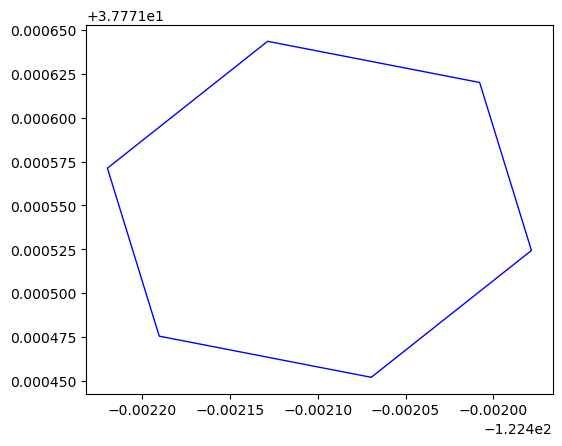

In [15]:
gp_df_weekday.loc[[0], "geometry"].plot(facecolor='none', edgecolor = "blue", linewidth=1)

[]

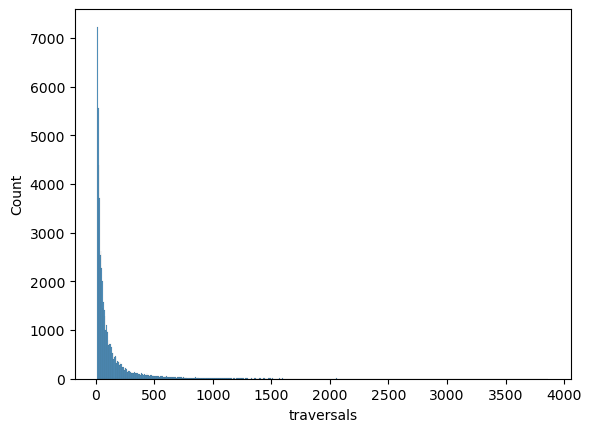

In [16]:
sns.histplot(gp_df_weekday["traversals"])
plt.plot()

In [17]:
gp_df_weekday["Traversal Bucket"].value_counts()

i. 0-50         26060
ii. 50-100      12736
iii. 100-200     9604
iv. 200-500      7031
v. 500-1000      2545
vi. 1000+         879
Name: Traversal Bucket, dtype: int64

In [18]:
gp_df_weekday.crs = "EPSG:4326"
gp_df_weekday = gp_df_weekday.to_crs(epsg=3857)

In [19]:
colors = ["Blue", "Green"]

ax = gp_df_weekday.plot(column = "Traversal Bucket", legend = True, figsize=(10, 10), alpha=1.0)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gp_df_weekday.crs.to_string())
plt.show()

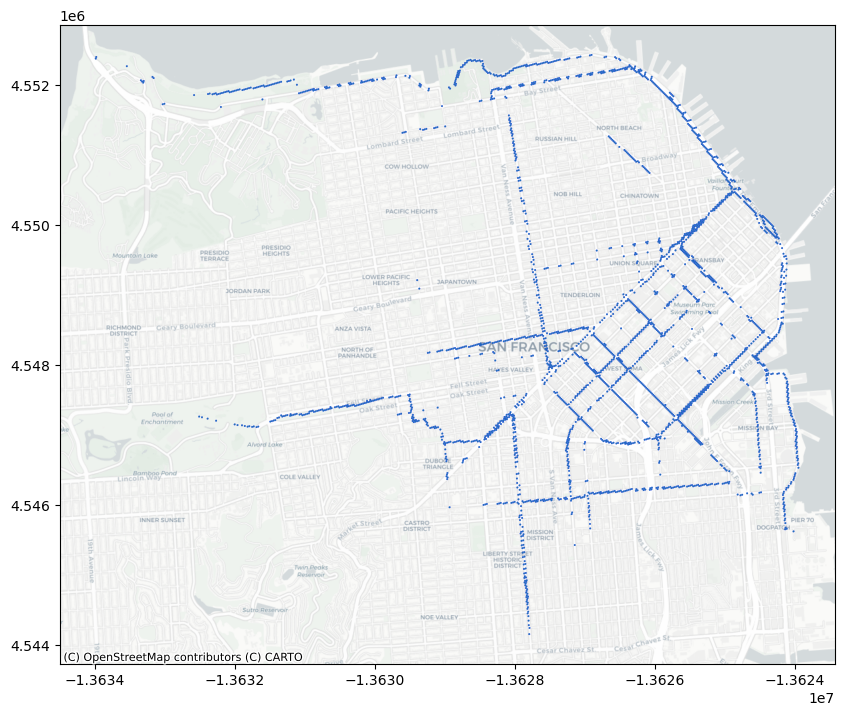

In [20]:
ax = gp_df_weekday[gp_df_weekday["Traversal Bucket"] == "v. 500-1000"].plot(edgecolor = "blue", linewidth=0.1, figsize=(10, 10), alpha=1.0)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gp_df_weekday[gp_df_weekday["Traversal Bucket"] == "v. 500-1000"].crs.to_string())
plt.show()

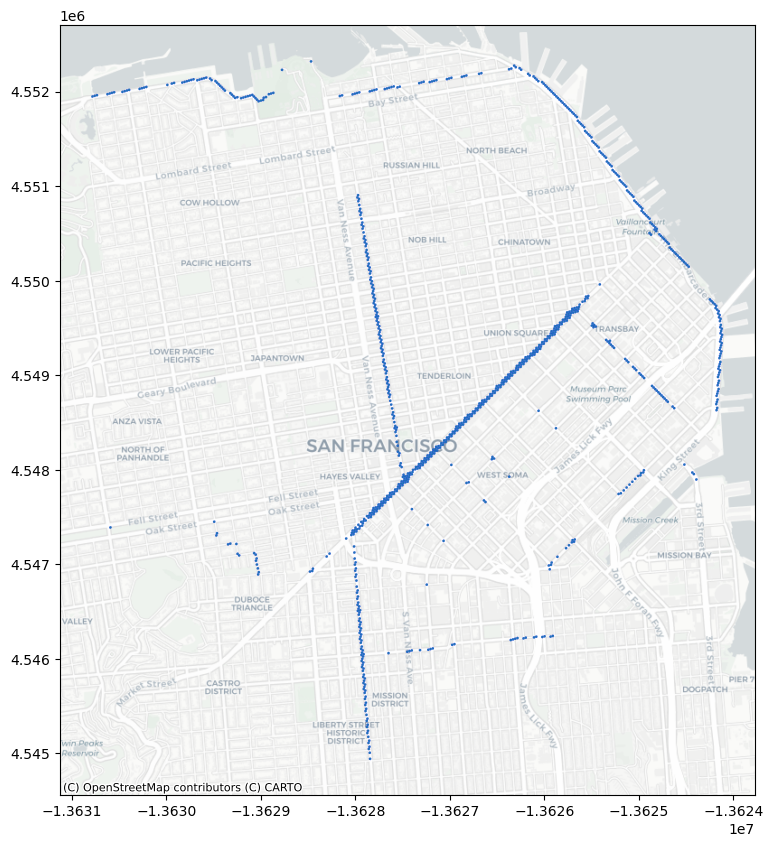

In [21]:
ax = gp_df_weekday[gp_df_weekday["Traversal Bucket"] == "vi. 1000+"].plot(edgecolor = "blue", linewidth=0.1, figsize=(10, 10), alpha=1.0)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gp_df_weekday[gp_df_weekday["Traversal Bucket"] == "vi. 1000+"].crs.to_string())
plt.show()

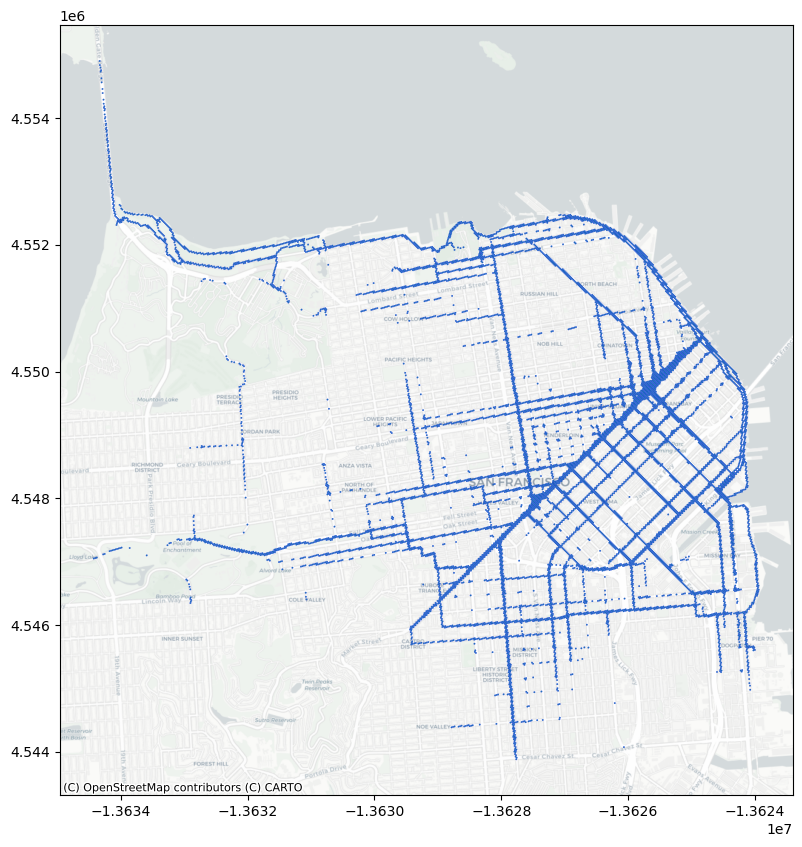

In [22]:
ax = gp_df_weekday[gp_df_weekday["traversals"] >= 200].plot(edgecolor = "blue", linewidth=0.1, figsize=(10, 10), alpha=1.0)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gp_df_weekday[gp_df_weekday["traversals"] >= 200].crs.to_string())
plt.show()

In [23]:
gp_df_weekday.centroid

0        POINT (-13625739.340 4547203.260)
1        POINT (-13625746.218 4547179.591)
2        POINT (-13625800.331 4547142.162)
3        POINT (-13625979.407 4547046.663)
4        POINT (-13626029.630 4547097.030)
                       ...                
58850    POINT (-13627610.100 4546939.785)
58851    POINT (-13634232.207 4548993.395)
58852    POINT (-13630364.423 4545789.892)
58853    POINT (-13626096.228 4550067.699)
58854    POINT (-13627625.677 4543685.643)
Length: 58855, dtype: geometry

In [24]:
gp_df_weekday["Centroid X"] = gp_df_weekday.centroid.x
gp_df_weekday["Centroid Y"] = gp_df_weekday.centroid.y

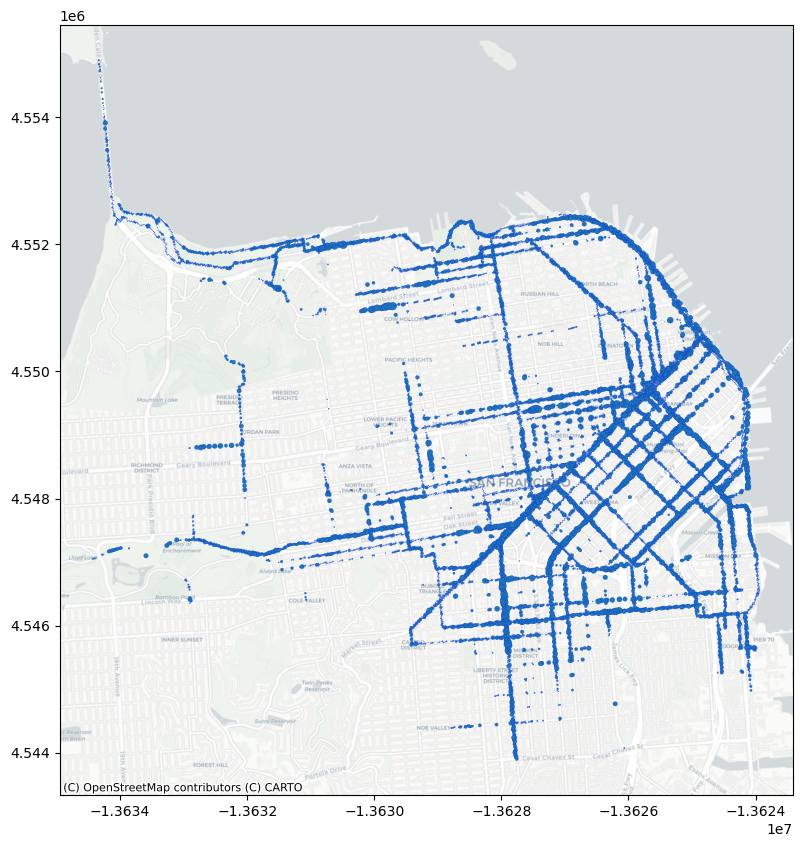

In [25]:
ax = gp_df_weekday[gp_df_weekday["traversals"] >= 200].centroid.plot(figsize=(10, 10), alpha=1.0,  edgecolor='blue', linewidth=0.1, markersize = 0.01* gp_df_weekday["traversals"])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.show()

In [26]:
kmeans = KMeans(n_clusters=1000, random_state=0, max_iter=1000)

In [27]:
#https://medium.com/@dey.mallika/unsupervised-learning-with-weighted-k-means-3828b708d75d
X = np.array(gp_df_weekday[["Centroid X", "Centroid Y"]]).astype(float)
Y = np.array(gp_df_weekday['traversals'].astype(float))

In [28]:
kmeans = KMeans(n_clusters=1000, random_state=0, max_iter=1000)
wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
predicted_kmeans = kmeans.predict(X, sample_weight = Y)
gp_df_weekday["predicted_kmeans_weighted_1000"] = predicted_kmeans

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


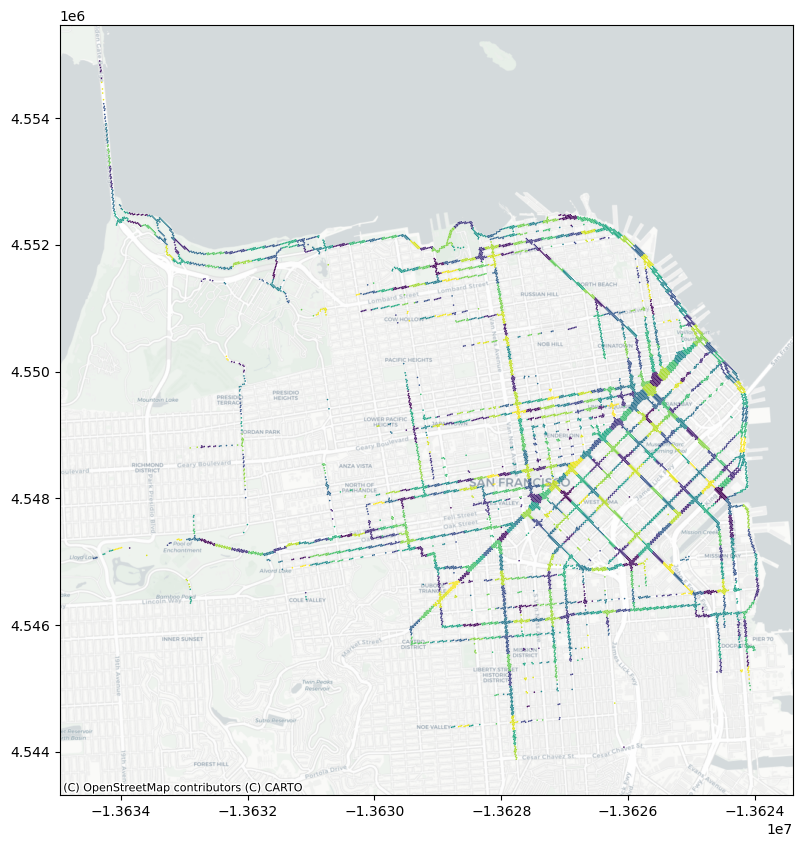

In [29]:
ax = gp_df_weekday[gp_df_weekday["traversals"] >= 200].plot(column = "predicted_kmeans_weighted_1000", figsize=(10, 10), alpha=1.0, linewidth=0.1, markersize = 0.01* gp_df_weekday["traversals"])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.show()

In [30]:
kmeans = KMeans(n_clusters=100, random_state=0, max_iter=1000)
wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
predicted_kmeans = kmeans.predict(X, sample_weight = Y)
gp_df_weekday["predicted_kmeans_weighted_100"] = predicted_kmeans

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


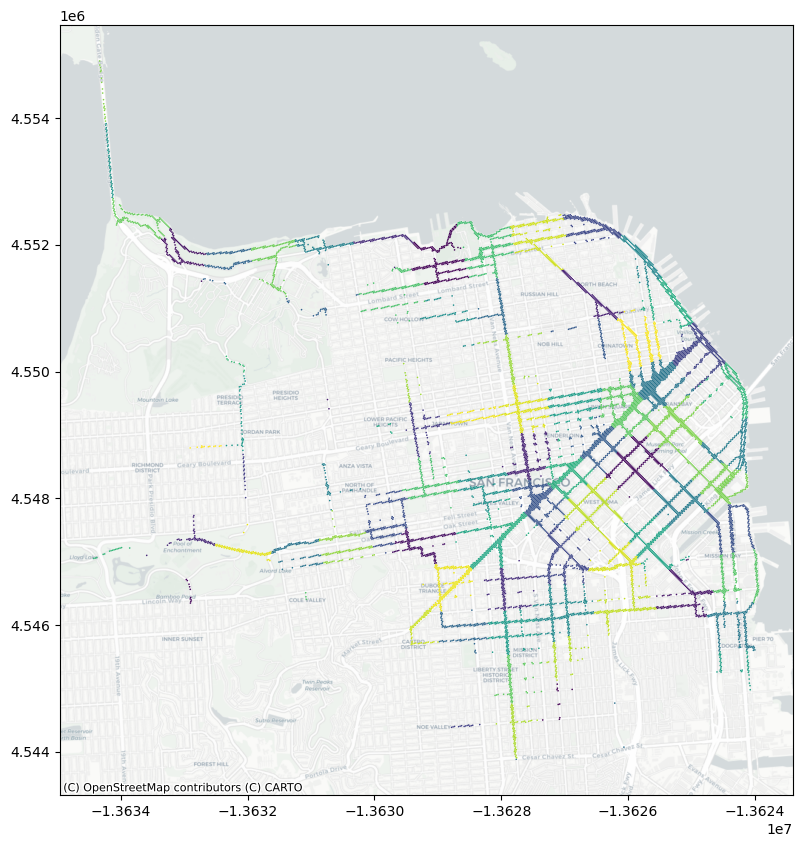

In [31]:
ax = gp_df_weekday[gp_df_weekday["traversals"] >= 200].plot(column = "predicted_kmeans_weighted_100", figsize=(10, 10), alpha=1.0, linewidth=0.1, markersize = 0.01* gp_df_weekday["traversals"])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.show()

In [32]:
kmeans = KMeans(n_clusters=50, random_state=0, max_iter=1000)
wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
predicted_kmeans = kmeans.predict(X, sample_weight = Y)
gp_df_weekday["predicted_kmeans_weighted_50"] = predicted_kmeans

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


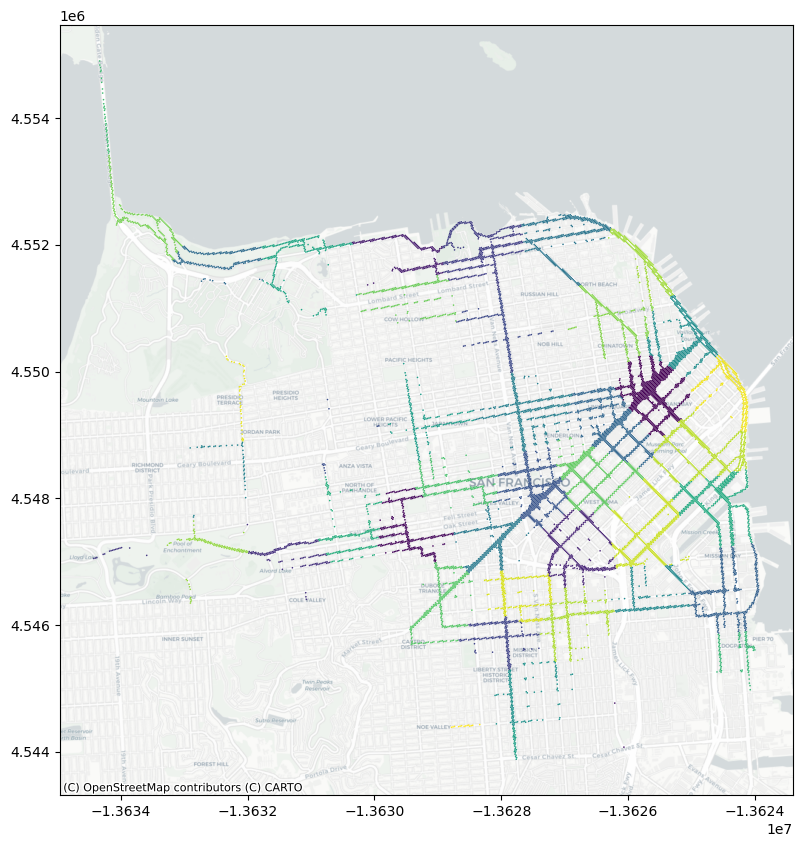

In [33]:
ax = gp_df_weekday[gp_df_weekday["traversals"] >= 200].plot(column = "predicted_kmeans_weighted_50", figsize=(10, 10), alpha=1.0, linewidth=0.1, markersize = 0.01* gp_df_weekday["traversals"])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.show()